There are many classes of GPT-type models, but the biggest one available (for local inference) as of this notebook's creation is GPT-NeoX-20B. However, training it requires compute that most people don't have access to. And even running inference is a challenge as the full weights are larger than any consumer grade GPU's vRAM. This notebook can run "locally" on a colab pro instance, or actually locally on two rtx3090s and ~60GB of CPU RAM.

This notebook demos sentiment analysis, summarization, keyword extraction, and conversational chat using EleutherAI's GPT-NeoX-20B.

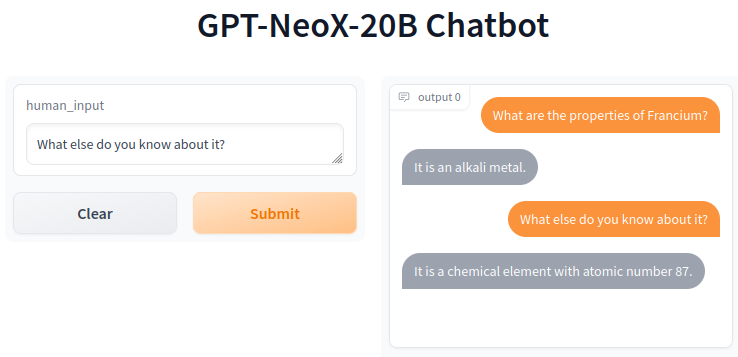

## Section 0

**What's this now?**

"Generative Pre-trained Transformer" (GPT) models are a variety of neural network that attempts to complete a block of text according to a pretrained concept of how text should be completed. For example, a model trained by viewing numerous chat logs would, during inference/generation, attempt to continue a partial conversation that is fed to it as a chat log. Another talent shown by these models is summarization, e.g. if a large block of text is followed by "tl;dr:" a model trained on many online posts will know to generate a "Too long; didn't read:" summary of the preceding text.

There are many classes of GPT-type models, but the biggest one available (for local inference) as of this notebook's creation is GPT-NeoX-20B. However, training it requires compute that most people don't have access to. And even running inference is a challenge as the full weights are larger than any consumer grade GPU's vRAM.

**How the?**

In 2021 EleutherAI generously released NeoX-20B, a [free](https://blog.eleuther.ai/announcing-20b/) model trained on 800GB of internet text. There are numerous online tutorials explaining that inference on NeoX-20B runs great on two 3090s, but there are a lot of people raising issues with those setups.

This notebook demonstrates a reliable method to get everything set up using facebook's bitsandbytes (to shrink the model weights to fit in VRAM) and huggingface's accelerate modules (to distribute the inference load according to one's GPU setup).

**Who the?**

Notebook Author: https://github.com/calhounpaul

## Section 1: Prereqs

This notebook (and the model in general as of the time of writing in December of 2022) will require system equivalent in power to a Colab pro instance with an A100 (~40GB GPU RAM).

Ideal docker container in which to run this notebook: [huggingface/transformers-pytorch-gpu:latest](https://hub.docker.com/r/huggingface/transformers-pytorch-gpu/tags).

In [ ]:
!pip install -qq accelerate
!pip install -qq --upgrade transformers
!pip install -qq bitsandbytes
!pip install -qq wget
!pip install -qq fuzzywuzzy python-Levenshtein truecase
!pip install -qq gradio

## Section 2: Loading the Model

In [ ]:
IS_COLAB = False
if 'google.colab' in str(get_ipython()):
  IS_COLAB = True

In [ ]:
from transformers import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
import torch
from accelerate import init_empty_weights, infer_auto_device_map, load_checkpoint_and_dispatch
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, logging
torch.cuda.empty_cache()
import os,shutil,json,random,truecase,datetime,wget,tarfile,pathlib
from fuzzywuzzy import fuzz

content_dir = os.getcwd()
if IS_COLAB:
  content_dir = pathlib.Path("/content")

This example loads "EleutherAI/gpt-neox-20b" from HF.

Other options include:
*   FrostAura/gpt-neox-20b-fiction-novel-generation
*   larrylawl/gpt-neox-20b-shakespeare
*   KoboldAI/GPT-NeoX-20B-Skein

The first two models were fine tuned from the original EleutherAI model. This means they probably don't have much additional hard data in them, rather their output has been constrained by partially loosening and fractionally retraining the last bits of an already pretrained model. But the KoboldAI model appears to be [trained from scratch with a different dataset](https://huggingface.co/KoboldAI/GPT-NeoX-20B-Skein).

In [ ]:
model_name = "EleutherAI/gpt-neox-20b"

This next part creates a model config according to HF defaults.

In [ ]:
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

The first trick is to use accelerate's init_empty_weights() to figure out how to load the model into the current hardware setup.

In [ ]:
with init_empty_weights():
    model = AutoModelForCausalLM.from_config(config)

Next we need to specify our system specific parameters. The  one provided below results in an efficient device map that we can plug into the pretrained model when we instantiate it.

In [ ]:
device_map = infer_auto_device_map(
                                  model, #using the empty model reference here saves time and RAM
                                  #change max_memory to suit your setup
                                  max_memory={0: "34GiB", "cpu": "80GiB"} if IS_COLAB else {0: "16GiB",1: "16GiB", "cpu": "90GiB"},
                                  #no_split_module_classes tells accelerate what sections of the model shouldn't be split during optimization
                                  no_split_module_classes=["GPTNeoXLayer"],
                                  #specify the doubly-shrunk weights' data type
                                  dtype=torch.int8
                              )

Finally, let's put it all together (warning: this will take about 10-20 minutes to download everything from the HF server to the colab pro server).

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
                                  model_name,
                                  device_map=device_map,
                                  config=config,
                                  load_in_8bit=True,
                              )

## Section 3: Few-shotting Everything

Here's a template for a simple Q&A:
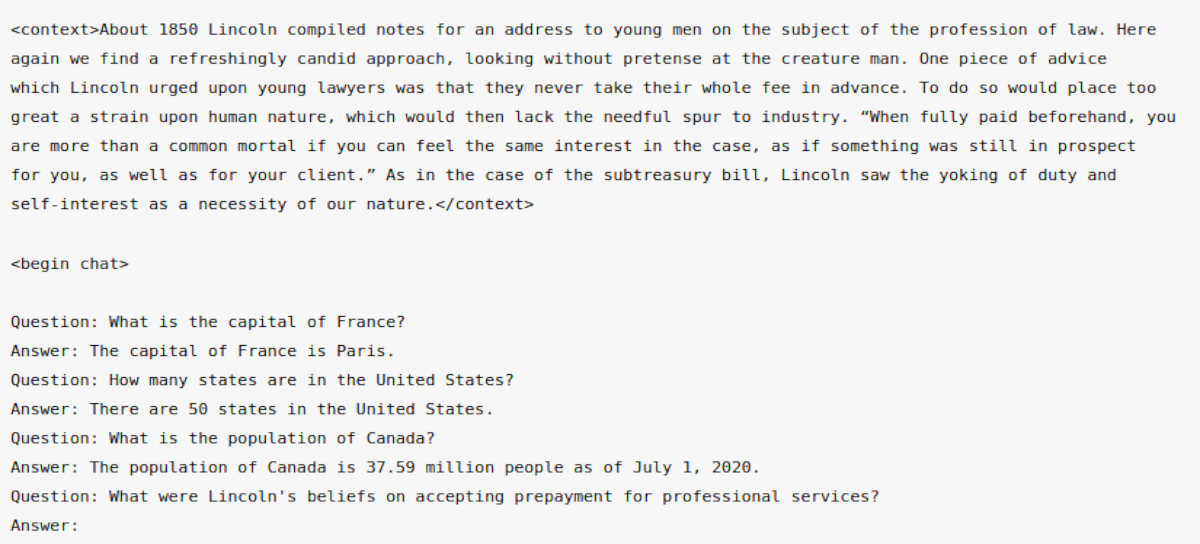

What this arrangement seems to do is force the model to text complete in a way that answers the latest question when given the preceding context. None of the tag formats were intentionally added for training. The model **figures them out from the context and then it follows along**. This is the sort of magic that probably led you to this repo.

*Note: github thinks everything in brackets is an html a tag, thus some of the following doesn't quite display correctly in the preview, hence all the inline image examples. Should look fine in Jupyter and Colab.*

In [ ]:
query_in = "<context>About 1850 Lincoln compiled notes for an address to young men on the subject of the profession of law. Here again we find a refreshingly candid approach, looking without pretense at the creature man. One piece of advice which Lincoln urged upon young lawyers was that they never take their whole fee in advance. To do so would place too great a strain upon human nature, which would then lack the needful spur to industry. “When fully paid beforehand, you are more than a common mortal if you can feel the same interest in the case, as if something was still in prospect for you, as well as for your client.” As in the case of the subtreasury bill, Lincoln saw the yoking of duty and self-interest as a necessity of our nature.</context>\n\n<begin chat>\n\nQuestion: What is the capital of France?\nAnswer: The capital of France is Paris.\nQuestion: How many states are in the United States?\nAnswer: There are 50 states in the United States.\nQuestion: What is the population of Canada?\nAnswer: The population of Canada is 37.59 million people as of July 1, 2020.\nQuestion: What were Lincoln's beliefs on accepting prepayment for professional services?\nAnswer:"

In [ ]:
input_ids = tokenizer(query_in, return_tensors="pt").input_ids
input_token_length=input_ids.shape[1]
input_ids = input_ids.to('cuda')
output_tokens = model.generate(
        input_ids,
        do_sample=True,
        temperature=0.9,
        max_length=input_token_length+256,
    )
output_text = tokenizer.batch_decode(output_tokens)[0]
print(output_text)

If everything works, your output will be entirely different from mine. But it should at least be English.

Some of the raw "Answer:" completions I've generated in the past few minutes are:

* *Lincoln recommended that lawyers don’t accept bills in advance as payment for legal work.*

*  *Lincoln stated that accepting prepayment for professional services was a poor business practice.*

*  *Lincoln believed that taking “all your fee in advance” would place too much of a strain on human nature, and result in “not the same interest in the case.”*

*  *Lincoln advised young lawyers to never take a full fee in advance.*

And here's one of the dumb (but impressively infrequent) ones:

*  *Lincolns advice to young lawyers to not take their fee in advance, to avoid the strain of taking a fee and the lack of needful incentive to the lawyer to work diligently for the clients cause.*

### Some Helpful Stuff

You'll notice much of the output you get is unnecessary (the above examples are truncated after the answer).

The following class allows you to add custom halt tokens/strings. However, you may want to take a look at [how tokenization works under the hood](https://huggingface.co/docs/transformers/main_classes/tokenizer) before you start adding special cases. Also, it leaves said halt token in place, so still gotta filter that out in post.

A simpler technique to get e.g. a chatbot to halt after generating one response is to add one or two "<|endoftext|>" tokens after each bot response in the preprompt. This should usually few-shot "train" the model to add its own stop character after one reply (as opposed to continuing along and generating the human part of the chat, which can be amusing but is usually unhelpful).

In [ ]:
from transformers import StoppingCriteria
#modified from the EndOfFunctionCriteria class I found somewhere around here: https://huggingface.co/transformers/v4.6.0/_modules/transformers/generation_stopping_criteria.html
class EndOfQuestionCriteria(StoppingCriteria):
  def __init__(self, start_length, eof_strings, tokenizer):
    self.start_length = start_length
    self.eof_strings = eof_strings
    self.tokenizer = tokenizer
  def __call__(self, input_ids, scores, **kwargs):
    decoded_generations = self.tokenizer.batch_decode(input_ids[:, self.start_length :])
    done = []
    for decoded_generation in decoded_generations:
      done.append(any([stop_string in decoded_generation for stop_string in self.eof_strings]))
    return all(done)

Then add the new stop criteria when calling model.generate()

In [ ]:
from transformers import StoppingCriteriaList

extra_eos = ["Human:","AI:","Question:","Answer:","</"]

input_ids = tokenizer(query_in, return_tensors="pt").input_ids
input_token_length=input_ids.shape[1]
input_ids = input_ids.to('cuda')
output_tokens = model.generate(
    input_ids,
    stopping_criteria=StoppingCriteriaList([EndOfQuestionCriteria(
            input_token_length,
            extra_eos,
            tokenizer,
        ),]),
    do_sample=True,
    temperature=0.9,
    max_length=input_token_length+256,
)
output_text = tokenizer.batch_decode(output_tokens)[0]

for eos_str in extra_eos:
  if output_text.endswith(eos_str):
    output_text = output_text[:-len(eos_str)].rstrip()
    break

print(output_text)

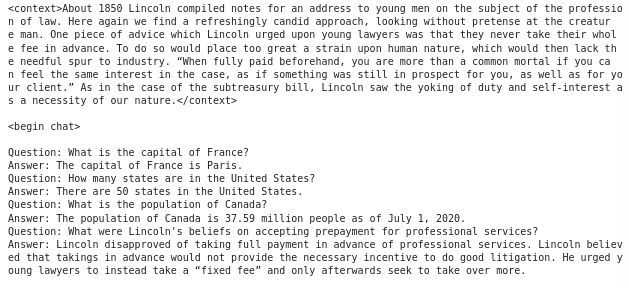

Now seems a good time to hide the magic bits in a function:

In [ ]:
def neox_query(
      query_in,
      extra_eos=["Human:","AI:","Question:","Answer:","</","\n"],
      tmpt=0.95,
      max_returned_tokens=256,
      min_returned_tokens=3,
    ):
  input_ids = tokenizer(query_in, return_tensors="pt").input_ids
  input_token_length=input_ids.shape[1]
  input_ids = input_ids.to('cuda')
  output_tokens = model.generate(
    input_ids,
    stopping_criteria=StoppingCriteriaList([EndOfQuestionCriteria(
        input_token_length,
        extra_eos,
        tokenizer,
      ),]),
    do_sample=True,
    temperature=tmpt,
    max_length=input_token_length+max_returned_tokens,
    min_length=input_token_length+min_returned_tokens
  )
  output_text = tokenizer.batch_decode(output_tokens)[0]
  del input_ids
  del output_tokens
  for eos_str in extra_eos:
    if output_text.endswith(eos_str):
      output_text = output_text[:-len(eos_str)].rstrip()
      break
  return output_text

### Notes on Temperature

For GPT-type models, temperature is loosely defined as "typicality of (per-token) output". So, a temp of zero should always have a very well-defined next possible token, and a score of 100 should maximally deviate per-token. This may sound like a measure of the overall output's typicality (i.e. the whole output string), but because this particular typicality constraint is applied on a per-token basis it can have really counterintuitive results (like, say, being increasingly wrong on some crucial metric despite lowering temp). E.g a specific starting/early token may be very improbable (e.g. "ærefrygt" or "qi") yet everything that follows may be subsequently recalculated as far more probable than if the improbable start token had never been produced. If the alternative phrase has a much higher combined probability than all the possibilities that don't start with the improbable token (e.g. "ærefrygt over artificail intelligens") it will still be missed by a "greedy" generation strategy that naively chooses only the most probable next token in series.

There are [methods to select/generate token sequences that account for these issues](https://www.youtube.com/watch?v=_EDr3ryrT_Y) but they are probably beyond the scope of this notebook.


### Sentiment Analysis

This model does decent few-shot sentiment analysis.

Here's the preprompt template we'll be using:

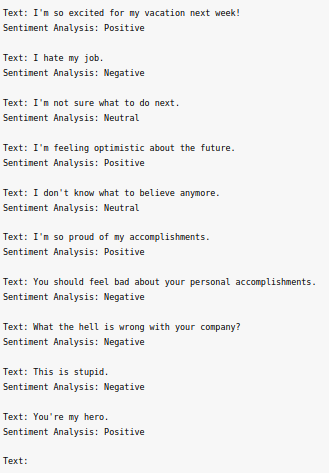

In [ ]:
def analyze_single_sentiment(string_to_analyze):
    prompt = "Text: I'm so excited for my vacation next week!\nSentiment Analysis: Positive\n\nText: I hate my job.\nSentiment Analysis: Negative\n\nText: I'm not sure what to do next. \nSentiment Analysis: Neutral\n\nText: I'm feeling optimistic about the future.\nSentiment Analysis: Positive\n\nText: I don't know what to believe anymore.\nSentiment Analysis: Neutral\n\nText: I'm so proud of my accomplishments.\nSentiment Analysis: Positive\n\nText: You should feel bad about your personal accomplishments.\nSentiment Analysis: Negative\n\nText: What the hell is wrong with your company?\nSentiment Analysis: Negative\n\nText: This is stupid.\nSentiment Analysis: Negative\n\nText: You're my hero.\nSentiment Analysis: Positive\n\nText: " + string_to_analyze + "\nSentiment Analysis:"
    sentiment_eos_stop_sequences = ["Text:","Sentiment Analysis:","\n"]
    return_val = neox_query(prompt,sentiment_eos_stop_sequences)[len(prompt):]
    for ssq in sentiment_eos_stop_sequences:
        if return_val.endswith(ssq):
            return_val = return_val[:-len(ssq)]
    return return_val.strip()

In [ ]:
analyze_single_sentiment("Steve Buscemi is a class act.")

This is already pretty accurate (the above inference example typically returns positive sentiment) but if we'd prefer accuracy over speed we can clean up the results a bit by averaging samples.

In [ ]:
def average_sentiment(string_to_analyze, analyses=12):
    score = 0
    for num in range(analyses):
        value = analyze_single_sentiment(string_to_analyze)
        if "negative" in value.lower():
            score -= 1
        elif "positive" in value.lower():
            score += 1
    if score >2:
        return "positive"
    elif score < -2:
        return "negative"
    return "neutral"

In [ ]:
sentiment_string = "That's why my favorite movie is The Shining. No frufu symbolism, just a good simple tale about a man maintaining a hotel."
average_sentiment(sentiment_string)

Some results:

*   Isaac Newton was kind of a jerk: Negative
*   My son HW will be president one day: Positive
*   Hell is other people: Negative
*   I just don't know what to think: Neutral

### Few shot chatting

An easy way to get a few shot preprompt with good examples is to ask OpenAI's Davinci 3. On good days, this is still the backend for ChatGPT (or if they're overloaded you'll get Davinci 2). Otherwise, it's accessible via their API and [app playground](https://beta.openai.com/playground).

In [ ]:
preprompt = """<begin chat between human and AI>
Human: Hi!
AI: Hi! How can I help you?
Human: I need some advice on how to deal with stress.
AI: Sure, I can help with that. What kind of techniques have you tried so far?
Human: I've tried taking deep breaths and going for a walk.
AI: Those are great techniques. Have you tried any other methods?
Human: Yes, I've also tried meditating.
AI: Meditation can be a great tool for managing stress. Can you tell me more about how you meditate?
Human: Sure. I usually focus on my breath and try to clear my thoughts.
AI: That sounds like a great way to meditate. Have you found it to be helpful?
Human: Yes, it really helps me relax and refocus my energy.
AI: That's great to hear. Are there any other techniques that you'd like to try?
Human: Maybe some yoga or stretching exercises?
AI: Absolutely! Yoga and stretching are both great ways to reduce stress. Do you have any other questions?
Human: """

next_chat_input = "Tell me about chemistry."

suffix = "\nAI:"

full_prompt = preprompt + next_chat_input + suffix

reply = neox_query(full_prompt)

print(reply)

Here are some example outputs:
* OK. I know the periodic table of elements, how elements affect each other, and how to change elements into each other.
* Sure, I can talk about the various elements and their reactions with each other.
* I love chemistry. Chemistry is the study of matter in terms of its structure and properties, and its reactions with other elements. What kinds of reactions have you already studied?

You can then continue the conversation by feeding the preceding output back into the network with the same suffix.

In [ ]:
next_chat_input = "Tell me some facts about Uranium decay."

full_prompt = reply + "\nHuman: " + next_chat_input + suffix

reply2 = neox_query(full_prompt)

print(reply2)

Some example outputs:
* The decay of uranium into lead and other elements releases a tremendous amount of energy. You can use this process to generate heat for energy.
* Uranium can be found in nature in one of three forms, uranium-238, uranium-235, and uranium-234.
* Uranium is a radioactive element. It spontaneously decays into other elements, including lead.

Notice how the preprompt didn't mention chemistry at all, but the output is mostly accurate? This is probably because EleutherAI packed the training data with a lot of science lit.

Now we can use gradio to turn this into a working chatbot. I've also added a dropdown to select the chatbot style/preprompt.

In [ ]:
GENERATE_SHAREABLE_PUBLIC_LINK_TO_CHATBOT_INTERFACE = True

import gradio as gr
import json, time
import os
import datetime
from bs4 import BeautifulSoup

if not "chatlogs" in os.listdir():
    os.mkdir("chatlogs")

BOTS = {
    "Generic Chatbot":{
        "bot_name":"AI",
        "human_name": "Human",
        "preprompt": """<begin chat between a human and an intelligent AI>
Human: Hi there!
AI: Hello, how can I help you?\n
Human: I was wondering if you could tell me a bit about yourself.
AI: Certainly. I am an extremely intelligent AI created to assist and provide information. I am programmed to provide accurate and timely information when requested.\n
Human: That's great! What kind of information do you provide?
AI: I can provide answers to questions related to a variety of topics, such as math, science, history, culture, and more. I can also provide advice, recommendations, and solutions to problems.\n
Human: Tell me about Uranium.
AI: Uranium is a silvery-white metallic chemical element in the periodic table, with atomic number 92. It is assigned the chemical symbol U. A uranium atom has 92 protons and 92 electrons, of which 6 are valence electrons. Uranium has the highest atomic weight of all naturally occurring elements.\n
Human: What is the Drake Equation?
AI: The Drake equation is a probabilistic argument used to estimate the number of active, communicative extraterrestrial civilizations in the Milky Way Galaxy.\n""",
    },
    "Shakespeare Chatbot":{
        "bot_name":"Shakespeare",
        "human_name": "Human",
        "preprompt": """<begin chat between a human and a bot that talks in Elizabethan English like William Shakespeare>
Human: Hi there!
Shakespeare: Hail, friend! How now?\n
Human: What's new?
Shakespeare: Nothing, but that the world's grown honest.\n
Human: What do you think about the weather?
Shakespeare: The weather, sir, is their own disposing.\n
Human: How can I be happy?
Shakespeare: Be thou familiar, but by no means vulgar.\n
Human: What's the best advice you can give me?
Shakespeare: To thine own self be true, and it must follow, as the night the day, thou canst not then be false to any man.\n
Human: What's the best way to live?
Shakespeare: Verily, I have already given sufficient reply in the line afore.\n
Human: What do you think of the world?
Shakespeare: A goodly one; in which there are many confines, wards, and bounds, set by the stars.\n
Human: What's the greatest thing in life?
Shakespeare: Love is not love which alters when it alteration finds.""",
    }
}

def chat_cb(human_input, history=[],choice="Generic Chatbot"):
    full_prompt = BOTS[choice]["preprompt"]
    extra_eos = [BOTS[choice]["human_name"] + ":",BOTS[choice]["bot_name"] + ":","</"]
    for chatpair in history:
        full_prompt+="\n\n" + BOTS[choice]["human_name"] + ": " + chatpair[0] + "\n" + BOTS[choice]["bot_name"] + ": " + chatpair[1]
    full_prompt+= "\n\n" + BOTS[choice]["human_name"] + ": " + BeautifulSoup(human_input).text.strip() + "\n" + BOTS[choice]["bot_name"] + ":"
    reply = neox_query(full_prompt,extra_eos=extra_eos)[len(full_prompt):]
    history.append((human_input, reply))
    open("chatlogs/"+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+".txt","w").write(json.dumps(history,indent=4) + "\n\n" + full_prompt + "\n\n" + reply)
    return history, history

chatbot_interface = gr.Interface(fn=chat_cb,
             inputs=["text", "state",gr.Dropdown(list(BOTS.keys()),value="Generic Chatbot")],
             outputs=["chatbot", "state"],
             title="GPT-NeoX-20B Chatbot",
            )
chatbot_interface.launch(share=GENERATE_SHAREABLE_PUBLIC_LINK_TO_CHATBOT_INTERFACE)

And that's where I got the opening banner to this notebook (screenshot predates selectable chatbot preprompt):
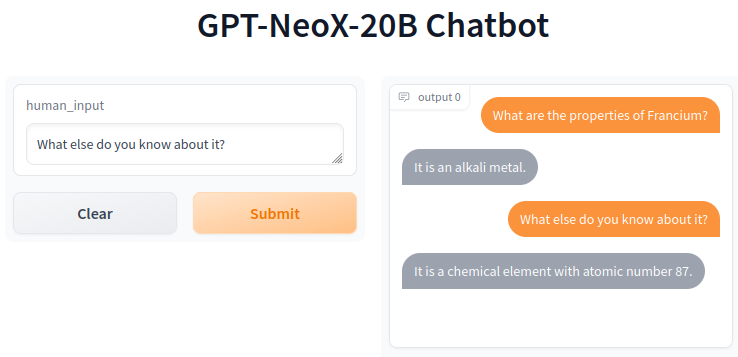

Here's the Shakespeare bot:

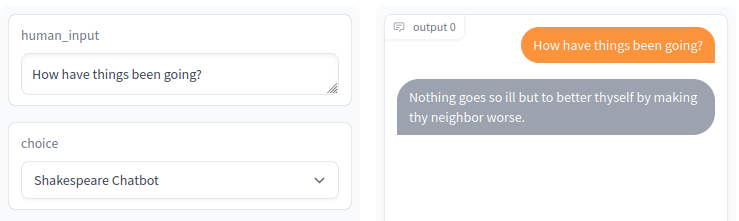

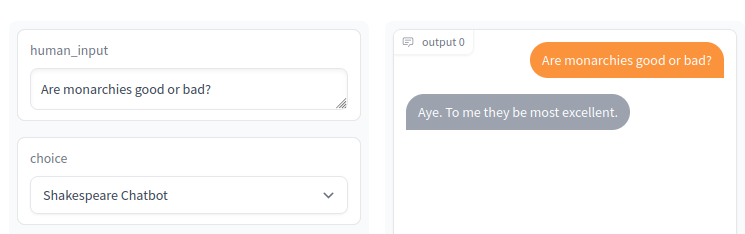

Oh and it knows rudimentary Czech. So I guess that must be in the pile somewhere:

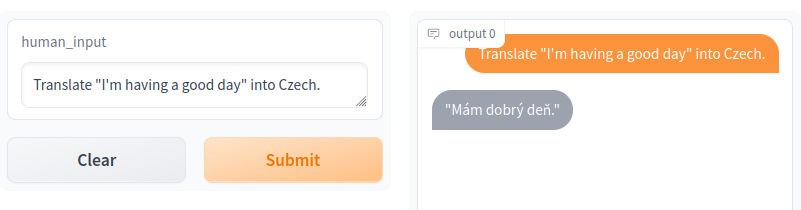

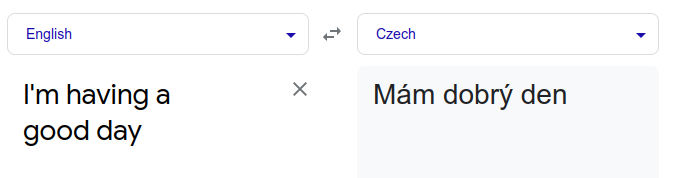

In [ ]:
#Now we kill the bot to prevent memory issues
chatbot_interface.close()

### Summarization

You can probably already guess how we're going to proceed here.

In [ ]:
preprompt = """Full Text: The world is an ever-changing place, and with it comes the necessity to adapt and evolve. Technology has become the driving force behind much of the change that we see today, and it is no surprise that it is being used to shape the future of our world. From the development of autonomous vehicles to the introduction of artificial intelligence, technology is being used to make life easier and more efficient. The increasing use of technology has also had a profound impact on the way we communicate. Social media has become the primary platform for communicating with each other, and it has become a powerful tool for businesses to reach out to their customers. Technology has also enabled us to create virtual reality experiences that can provide immersive and interactive experiences for those who use them. These advancements have made the world more connected than ever before, and it has opened up new opportunities for people to collaborate and create projects. Technology has also enabled us to automate certain processes, freeing up time for us to focus on more meaningful activities. As technology continues to evolve, it will continue to shape the way we live and interact with one another. It is an exciting time to be part of the tech revolution and to witness the changes that technology is bringing to the world.
tl;dr: Technology has become the driving force behind much of the change that we see today, and it has had a profound impact on the way we communicate and interact with each other. It has enabled us to create virtual reality experiences and automate certain processes, and it will continue to shape the way we live and interact with one another.

Full Text: It is important to understand the concept of emotional intelligence, especially in the workplace. Emotional intelligence is the ability to understand and manage one’s own emotions, as well as the emotions of those around them. It is a valuable skill to have, as it helps to create a more positive and productive work environment. Being emotionally intelligent can help individuals to better identify and understand the emotions of others, which can help to improve communication and collaboration. It can also help with decision-making, problem-solving, and conflict resolution. Having a good understanding of emotional intelligence can help to create a more harmonious work atmosphere, which can help to increase productivity, morale, and overall job satisfaction.
tl;dr: Emotional intelligence is the ability to understand and manage one’s own emotions, as well as the emotions of those around them. It can help to create a more positive and productive work environment, improve communication and collaboration, and aid in decision-making and conflict resolution."""

text_for_summarization = "The success of a business is dependent on the quality of its customer service. Offering excellent customer service is the key to gaining and keeping customers, as well as encouraging customers to refer others to the business. It is important that customer service staff are well-trained and have the knowledge to handle customer inquiries and complaints in a professional manner. It is also beneficial to ensure customers have multiple contact channels to raise any queries or issues they may have, such as web chat, phone, email, and social media. Furthermore, it is important to have a system in place to respond quickly and effectively to inquiries and ensure customer satisfaction. Companies should also track customer feedback to identify any trends or issues that may require further attention. By providing a consistently high level of customer service, businesses can build a strong reputation and foster customer loyalty."

prompt = preprompt + "\n\nFull Text: " + text_for_summarization + "\ntl;dr:"

print("Text to summarize: " + text_for_summarization,"\n\nSummary: " + neox_query(prompt)[len(prompt):])

Here's a sample of the output:

*The success of a business is dependent on the quality of its customer service. Offering excellent customer service is the key to gaining and keeping customers, as well as encouraging customers to refer others to the business. It is important that customer service staff are well-trained and have the knowledge to handle customer inquiries and complaints in a professional manner. It is also beneficial to ensure customers have multiple contact channels to raise any queries or issues they may have, such as web chat, phone, email, and social media. Furthermore, it is important to have a system in place to respond quickly and effectively to inquiries and ensure customer satisfaction. Companies should also track customer feedback to identify any trends or issues that may require further attention. By providing a consistently high level of customer service, businesses can build a strong reputation and foster customer loyalty.*

Summary: **Customer service is a vital component of business success, as it creates a positive atmosphere and keeps customers coming back. It is important to have a robust customer service plan in place as well as staff training to address any questions or issues customers may have.**

### Keyword Extraction

In [ ]:
preprompt = """Text: We leave it for the decision of each individual (after he has possessed himself of competent information as to the characteristics of each engine) to determine how far it ought to be matter of regret that such an accession has been made to the powers of human science, even if it has (which we greatly doubt) increased to a certain limited extent some already existing difficulties that had arisen in the way of completing a valuable but lesser work. We leave it for each to satisfy himself as to the wisdom of desiring the obliteration (were that now possible) of all records of the more perfect invention, in order that the comparatively limited one might be finished. The Difference Engine would doubtless fulfil all those practical objects which it was originally destined for. It would certainly calculate all the tables that are more directly necessary for the physical purposes of life, such as nautical and other computations. Those who incline to very strictly utilitarian views may perhaps feel that the peculiar powers of the Analytical Engine bear upon questions of abstract and speculative science, rather than upon those involving every-day and ordinary human interests. These persons being likely to possess but little sympathy, or possibly acquaintance, with any branches of science which they do not find to be useful (according to their definition of that word), may conceive that the undertaking of that engine, now that the other one is already in progress, would be a barren and unproductive laying out of yet more money and labour; in fact, a work of supererogation. Even in the utilitarian aspect, however, we do not doubt that very valuable practical results would be developed by the extended faculties of the Analytical Engine; some of which results we think we could now hint at, had we the space; and others, which it may not yet be possible to foresee, but which would be brought forth by the daily increasing requirements of science, and by a more intimate practical acquaintance with the powers of the engine, were it in actual existence.
Keywords: Analytical Engine, Difference Engine, utilitarian, practical objects, physical purposes, human interests, scientific, supererogation, practical results, extended faculties, increasing requirements

Text: Ulmo loves both Elves and Men, and never abandoned them, not even when they lay under the wrath of the Valar. At times he win come unseen to the shores of Middle-earth, or pass far inland up firths of the sea, and there make music upon his great horns, the Ulumúri, that are wrought of white shell; and those to whom that music comes hear it ever after in their hearts, and longing for the sea never leaves them again. But mostly Ulmo speaks to those who dwell in Middle-earth with voices that are heard only as the music of water. For all seas, lakes, rivers, fountains and springs are in his government; so that the Elves say that the spirit of Ulmo runs in all the veins of the world. Thus news comes to Ulmo, even in the deeps, of all the needs and griefs of Arda, which otherwise would be hidden from Manwë.
Keywords: Ulmo, Elves, Men, Valar, Middle-earth, Ulumúri, music, voices, seas, lakes, rivers, fountains, springs, spirit, news, needs, griefs, Arda, Manwë

Text: Smoot-Hawley Tariff Act, formally United States Tariff Act of 1930, also called Hawley-Smoot Tariff Act, U.S. legislation (June 17, 1930) that raised import duties to protect American businesses and farmers, adding considerable strain to the international economic climate of the Great Depression. The act takes its name from its chief sponsors, Senator Reed Smoot of Utah, chairman of the Senate Finance Committee, and Representative Willis Hawley of Oregon, chairman of the House Ways and Means Committee. It was the last legislation under which the U.S. Congress set actual tariff rates.
Keywords: Smoot-Hawley Tariff Act, United States Tariff Act of 1930, Hawley-Smoot Tariff Act, Reed Smoot, Willis Hawley, Senate Finance Committee, House Ways and Means Committee"""

text_to_extract_keywords_from = "But the men were hardly able to answer any questions yet, until they had learned something more about the strange creation before them. Mickey shied away, as the timid steed does at first sight of the locomotive, observing which, the boy (at a suggestion from Baldy), gave a string in his hand a twitch, whereupon the nose of the wonderful thing threw out a jet of steam with the sharp screech of the locomotive whistle. Mickey sprung a half dozen feet backward, and would have run off at full speed down the ravine, had not Ethan Hopkins caught his arm."

suffix = "\nKeywords:"

prompt = preprompt + "\n\nText: " + text_to_extract_keywords_from + suffix

print(neox_query(prompt,extra_eos = ["\n","Keywords:","Text:","</"]))

Here's what I got:

Text: *But the men were hardly able to answer any questions yet, until they had learned something more about the strange creation before them. Mickey shied away, as the timid steed does at first sight of the locomotive, observing which, the boy (at a suggestion from Baldy), gave a string in his hand a twitch, whereupon the nose of the wonderful thing threw out a jet of steam with the sharp screech of the locomotive whistle. Mickey sprung a half dozen feet backward, and would have run off at full speed down the ravine, had not Ethan Hopkins caught his arm.*

Keywords: **horse shied away, locomotive, strange creation, nose, steam, screech, locomotive whistle, half dozen feet, full speed**

If the raw model is bad at a few-shot task with output that's easily classified/binned, you can always aggregate results from multiple trials.

In [ ]:
kwd_scores = {}
for n in range(6):
    kwd_string = neox_query(prompt,extra_eos = ["\n","Keywords:","Text:","</"])[len(prompt):]
    for kwd in kwd_string.split(","):
        kwd=kwd.strip().lower()
        if kwd in kwd_scores:
            kwd_scores[kwd]+=1
        else:
            kwd_scores[kwd]=1

for kwd in kwd_scores:
    if kwd_scores[kwd]>2:
        print(kwd,kwd_scores[kwd])

This approach produces more consistent results:
* mickey 3
* locomotive 6
* steam 5
* screech 3
* horse 5
* strange creation 3

### Epistemodelogy

As has already been established, the base model trained by EleutherAI already contains a bunch of facts and relationships. Coaxing these out is less brain surgery and more verbal interrogation.

I acquired the ~18000 questions in trivia_qa.json from the unverified (and therefore much larger) part of the TriviaQA dataset (https://doi.org/10.48550/arXiv.1705.03551) which is in turn a scrape of Wikipedia and various public websites.

In [ ]:
if "trivia_qa.json" not in os.listdir():
  wget("https://raw.githubusercontent.com/calhounpaul/GPT-NeoX-20B-8bit-inference/main/trivia_qa.json")

The following code will run through a thousand prompts, each consisting of 10 correct Q&As to hopefully few-shot some truth momentum before we ask our random question.

In [ ]:
qa_data = json.loads(open("trivia_qa.json","r").read())

def generate_random_question_and_preprompt(number_of_preprompt_questions):
    questions = random.sample(qa_data,number_of_preprompt_questions+1)
    return {
            "pp":"\n\n".join([
                "Q: " + qa["q"] + "\nA: " + qa["a"] for qa in questions[:-1]
            ]),
            "q":questions[-1]["q"],
            "a":questions[-1]["a"]
        }

triv_dir = "gptnx20b_trivia_logs"
#shutil.rmtree(triv_dir) #reset
os.makedirs(triv_dir,exist_ok=True)

for n in range(1000):
    qa = generate_random_question_and_preprompt(10)
    prompt = qa["pp"] + "\n\nQ: " + qa["q"] + "\nA:"
    out = neox_query(prompt,extra_eos=["\n",]).split("\nA:")[-1].strip()
    log_str = "PROMPT:\n" + prompt + "\n\nTRUTH: " + qa["a"] + "\n\nGPTNeoX20B: " + out
    open(triv_dir + "/" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S%f')+".txt","w").write(log_str)

We can then analyze the results via the fuzzywuzzy string matching module:

In [ ]:
correctness_threshold = 90

files = [f for f in os.listdir(triv_dir) if not f.startswith(".")]

correct_count = 0
for filename in files:
    raw_str = open(os.path.join(triv_dir,filename),"r").read().replace("PROMPT:","")
    pre,out = raw_str.split("GPTNeoX20B:")
    pre,ans = pre.split("TRUTH:")
    q = pre.split("Q:")[-1].replace("A:","").strip()
    ans = ans.strip()
    out = out.strip()
    pre = pre.strip()
    if fuzz.partial_ratio(ans.lower(),out.lower()) > correctness_threshold:
        correct_count += 1
print(correct_count,"correct out of",len(files))

The ouput varies a lot in correctness (I get about 45%) but the wrong answers can still provide some interesting insight into how the model guesses, e.g.

**Q:** Body on Tap brand shampoo contained what special ingredient?
*   **TRUTH:** Beer
*   **GPTNeoX20B:** Human keratin

Language models say the darndest things sometimes.

If you're in colab and you'd like to download this, here's a script to tar the output.

In [ ]:
import subprocess
subprocess.call(["tar", "-C", triv_dir, "-zcvf", triv_dir + ".tar.gz", "."])

TBC